In [80]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [81]:
data_path=os.getcwd()+'\\data'
df=pd.read_csv(data_path+'\\CTU13_LabelCluster.csv', sep=',')
print(df.shape)

(107251, 15)


In [82]:
print('---- Head before transformation ----')
print(df.head())

---- Head before transformation ----
                      StartTime           Dur Proto        SrcAddr  Sport  \
0  jueves, 18 de agosto de 2011  8.306214e+14   tcp  147.32.84.202   1078   
1  jueves, 18 de agosto de 2011  4.977205e+15   tcp    88100184137  13121   
2  jueves, 18 de agosto de 2011  9.712881e+15   tcp    147.32.84.2     80   
3  jueves, 18 de agosto de 2011  8.999964e+15   tcp   90.181.84.58  54518   
4  jueves, 18 de agosto de 2011  3.875344e+14   tcp  147.32.86.116  19083   

   Dir        DstAddr  Dport    State  sTos  dTos  TotPkts   TotBytes  \
0  <?>   65.54.89.106     80  RPA_FPA     0     0    43065   40974671   
1  <?>   147.32.85.26  62860   RPA_PA     0     0   326962  132430976   
2  <?>  218.75.208.58   3088     PA_A     0     0     7912    7356876   
3  <?>   147.32.84.19    993    PA_PA     0     0       48       5728   
4   ?>   151.82.9.107   2185     RPA_     0     0        7        456   

   SrcBytes            Label  
0   1033777  flow=Background  

In [83]:
df['Label'].value_counts()

flow=Background                     63831
flow=To-Background                  31451
flow=From-Botnet                     8164
flow=From-Normal                     2709
flow=Background-google-analytics     1039
flow=From-Background                   48
flow=To-Normal                          8
flow=Normal                             1
Name: Label, dtype: int64

In [84]:
print('---- Data types before transformation ----')
print(df.dtypes)

---- Data types before transformation ----
StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos           int64
dTos           int64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label         object
dtype: object


In [85]:
# Transform to numeric values (Proto, Dir, <<State>>, Label)
# Proto
PROTO = "Proto_Encoded"
protoLE = preprocessing.LabelEncoder()
df[PROTO] = protoLE.fit_transform(df["Proto"].values.ravel())

# Dir
DIR = "Dir_Encoded"
dirLE = preprocessing.LabelEncoder()
df[DIR] = dirLE.fit_transform(df["Dir"].values.ravel())

# Label
LABEL = "Label_Encoded"
le = preprocessing.LabelEncoder()
df[LABEL] = le.fit_transform(df["Label"].values.ravel())

In [86]:
df.drop(['StartTime','State' ,'SrcAddr','DstAddr', 'Proto', 'Dir'], axis=1, inplace= True)

In [87]:
df = df.dropna('columns')
df = df[[col for col in df if df[col].nunique() > 1]]

C:\Users\Arnau\AppData\Local\Temp\ipykernel_11880\794676061.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


In [88]:
print('---- Data types after transformation ----')
print(df.dtypes)
print('---- Head after transformation ----')
print(df.head())

---- Data types after transformation ----
Dur              float64
sTos               int64
dTos               int64
TotPkts            int64
TotBytes           int64
SrcBytes           int64
Label             object
Proto_Encoded      int32
Dir_Encoded        int32
Label_Encoded      int32
dtype: object
---- Head after transformation ----
            Dur  sTos  dTos  TotPkts   TotBytes  SrcBytes            Label  \
0  8.306214e+14     0     0    43065   40974671   1033777  flow=Background   
1  4.977205e+15     0     0   326962  132430976   7076046  flow=Background   
2  9.712881e+15     0     0     7912    7356876   7153650  flow=Background   
3  8.999964e+15     0     0       48       5728      3008  flow=Background   
4  3.875344e+14     0     0        7        456       456  flow=Background   

   Proto_Encoded  Dir_Encoded  Label_Encoded  
0             10            4              0  
1             10            4              0  
2             10            4              0  
3

C:\Users\Arnau\AppData\Local\Temp\ipykernel_11880\904150308.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


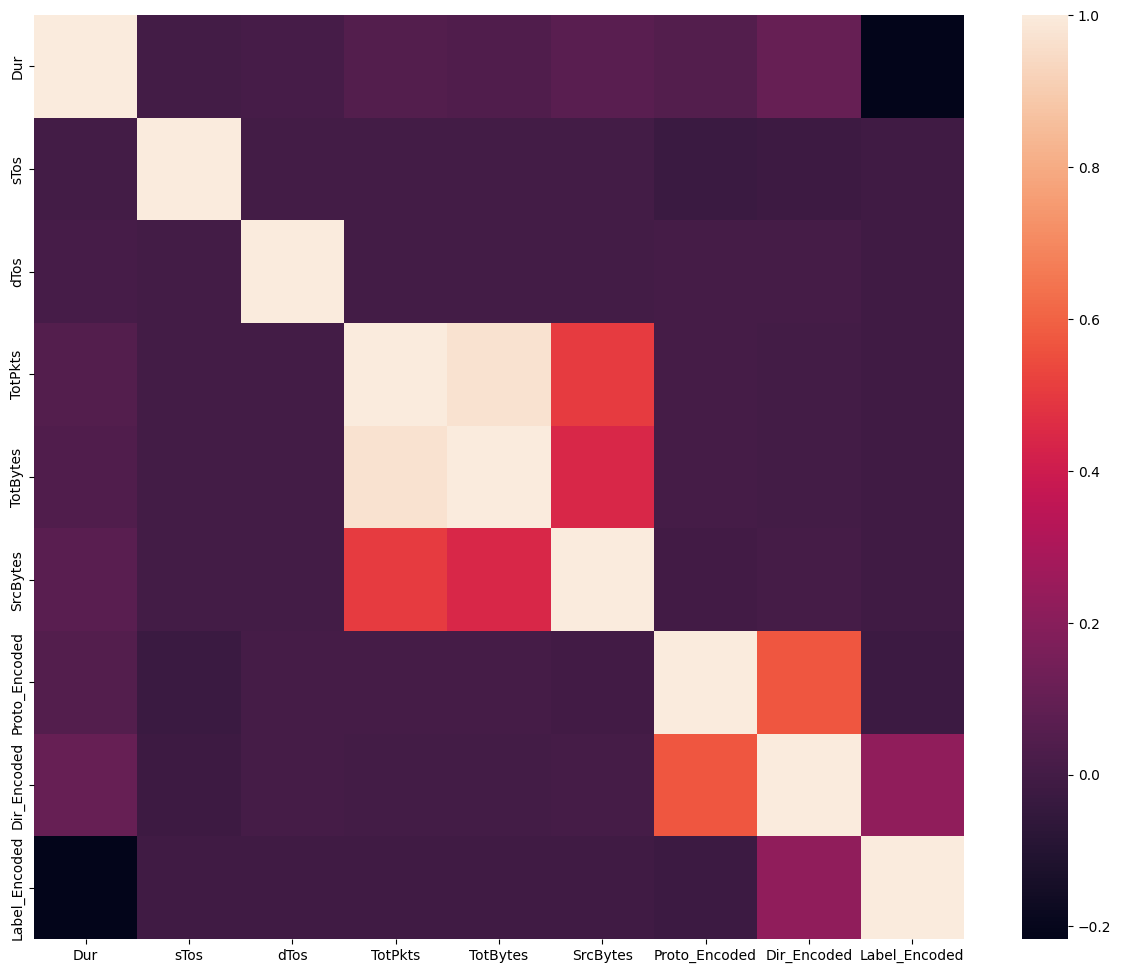

In [89]:
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

In [90]:
print('Shape before feature reduction: ', df.shape)

Shape before feature reduction:  (107251, 10)


In [92]:
cor_thr=0.98
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > cor_thr)]
print('Features to drop: ', to_drop)
for i in to_drop:
    df.drop(i,axis = 1,inplace = True)
print('Shape after feature reduction: ', df.shape)
print('Rows: ', df.shape[0])
print('Features: ', df.shape[1])

Features to drop:  []
Shape after feature reduction:  (107251, 10)
Rows:  107251
Features:  10


C:\Users\Arnau\AppData\Local\Temp\ipykernel_11880\4008394199.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()
C:\Users\Arnau\AppData\Local\Temp\ipykernel_11880\4008394199.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [93]:
def create_segments_and_labels(df, time_steps, step, label_name):
    N_FEATURES = df.shape[1] - 2 # Label + Label Encoded
    segments = []
    labels = []
    index_Seg = 0
    
    for i in range(0, len(df) - time_steps, step): # 80 x 38
        seg = []
        for column in df:
            if (column != 'Label' and column != label_name):
                fs = df[column].values[i: i + time_steps]
                seg.append(fs)
        segments.append(seg)        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        labels.append(label)
        index_Seg+=1

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

X_train, Y_train = create_segments_and_labels(df,
                                              80,
                                              40,
                                              LABEL)
print('-------------BEFORE SPLIT--------------------')
print('x_train', X_train.shape)
print('y_train', Y_train.shape)

# Split test and train data 
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)
print('-------------AFTER SPLIT--------------------')
print('x_train', X_train.shape)
print('y_train', Y_train.shape)
print('X_validation', X_validation.shape)
print('Y_validation', Y_validation.shape)


C:\Users\Arnau\AppData\Local\Temp\ipykernel_11880\400802421.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


-------------BEFORE SPLIT--------------------
x_train (2680, 80, 8)
y_train (2680,)
-------------AFTER SPLIT--------------------
x_train (2144, 80, 8)
y_train (2144,)
X_validation (536, 80, 8)
Y_validation (536,)


In [ ]:
# X_train = np.reshape(X_train, (1, X_train.shape[0], X_train.shape[1]))
# X_validation = np.reshape(X_validation, (1, X_validation.shape[0], X_validation.shape[1]))
# print('Shape after reshape X_train:', X_train.shape)
# print('Shape after reshape X_validation:', X_validation.shape)

# Y_train = np_utils.to_categorical(Y_train, 5)
# Y_validation = np_utils.to_categorical(Y_validation, 5)
# print('New Y_train shape: ', Y_train.shape)
# print('New Y_validation shape: ', Y_validation.shape)

# Formato actual:
    # INPUT: (1, 200k, 38)  --> 1 segmento de 200k rows por 38 features.
    # OUTPUT: (200k, 5) --> 200k resultados, 1 por cada segmento, de 5 labels con sus porcentajes.
# Problema: y_train tiene que mostrar un resultado en formato (1, 5) 1 row con 5 porcentajes de resultado para cada segmento
# Implicación: y_train es el resultado para todo el segmento. En este caso segmento=1=todo dataset. --> INCORRECTO
# Replanteamiento:
    # formato (200k, 1, 38) --> cada row del dataset es 1 segmento de 1 row con 38 features.
    # y_train mostrarà formato (1, 5) 1 solo resultado para 1 segmento de 1 row.
    # Problema:
        # un modelo con layers que parten de un input = 1 no se puede modelar debido a la falta de downsampling
# Solucion:
    # FLOW AGREGATION = Segmento --> 1 mismo resultado para todo el segmento
    # formato entrada (segmentos, flows, 38)

rows_segment, features = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

input_shape = (rows_segment*features)
print('input_shape:', input_shape)

X_train = X_train.reshape(X_train.shape[0], input_shape)
print('x_train shape:', X_train.shape)
X_validation = X_validation.reshape(X_validation.shape[0], input_shape)
print('X_validation shape:', X_validation.shape)


# Convert type for Keras otherwise Keras cannot process the data
X_train = X_train.astype("float32")
X_validation = X_validation.astype("float32")

Y_train = Y_train.astype("float32")
Y_validation = Y_validation.astype("float32")

Y_train = np_utils.to_categorical(Y_train, num_classes)
print('New y_train shape: ', Y_train.shape)
Y_validation = np_utils.to_categorical(Y_validation, num_classes)
print('New Y_validation shape: ', Y_validation.shape)

In [ ]:
callback = EarlyStopping(monitor='acc', patience=1)

model_odcnn = Sequential()
model_odcnn.add(Reshape((rows_segment, features), input_shape=(input_shape,)))
model_odcnn.add(Conv1D(100, 10, activation='relu', input_shape=(rows_segment, features)))
model_odcnn.add(Conv1D(filters=100, kernel_size=10, activation='relu'))
model_odcnn.add(MaxPooling1D(3))   #---> output matrix després de maxpooling es 1/3 de input matrix
model_odcnn.add(Conv1D(160, 10, activation='relu'))
model_odcnn.add(Conv1D(160, 10, activation='relu'))
model_odcnn.add(GlobalAveragePooling1D())    #---> agafa nomes 1 weight de mitja
model_odcnn.add(Dropout(0.5))    #---> 50% random de les neurones rebran un weight=0
model_odcnn.add(Dense(num_classes, activation='softmax'))   # ---> reduir les 160 prediccions a la probabilitat corresponent entre les labels que tenim
print(model_odcnn.summary())


model_odcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_odcnn.fit(X_train,
                      Y_train,
                      batch_size=400,
                      epochs=50,
                      callbacks=[callback],
                      validation_split=0.2,
                      verbose=1)
# validation_data=(X_validation,Y_validation)

history_dict = history.history
history_dict.keys()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1, 2, 1)
plt.plot(range(0, 50), loss, 'g', label='Training loss', color='red')
plt.plot(range(0, 50), val_loss, 'g--', label='Val Training loss', color='green')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, 50), accuracy, 'g', label='Training acc', color='red')
plt.plot(range(0, 50), val_acc, 'g--', label='Training acc', color='green')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.ylim(0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(16, 14))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    
    
score = model_odcnn.evaluate(X_validation, Y_validation, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_odcnn.predict(X_validation)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_validation, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)